Section 0: Preamble
===================

These lectures assume the current working directory is `/path/to/autofit_workspace/` on your hard-disk (or in Binder).
This is so that it can:

 - Load configuration settings from config files in the `autofit_workspace/config` folder.
 - Load example data from the `autofit_workspace/dataset` folder.
 - Output the results of models fits to your hard-disk to the `autofit/output` folder.

If you don't have an autofit_workspace (perhaps you cloned / forked the **PyAutoLens** GitHub repository?) you can
download it here:

 https://github.com/Jammy2211/autofit_workspace

At the top of every lecture notebook, you'll see the following cell. This cell uses the project `pyprojroot` to
locate the path to the workspace on your computer and use it to set the working directory of the notebook.

The imports required for this lecture are also performed below.

In [1]:
import autofit as af
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import os
from os import path

2021-09-12 17:48:57,356 - autoconf.conf - WARNING - Pushing new config with path C:\Users\Jammy\Code\PyAuto\PyAutoFit\autofit\config


C:\Users\Jammy\Results\projects\ppl\Probabilistic_Programming_CDT
Working Directory has been set to `C:\Users\Jammy\Results\projects\ppl\Probabilistic_Programming_CDT`


Section 1: Model Composition
============================

First, we'll compose a simple model and show how **PyAutoFit** allows us to generate instances of the model, which
will allow us to fit the model to data later on.

__Data__

Throughout these tutorials we will fit noisy 1D data containing a signal, where the signal was generated using a
Gaussian.

These are loaded from .json files, where:

 - The data is a 1D numpy array of values corresponding to the observed counts of the Gaussian.
 - The noise-map corresponds to the expected noise value in every data point.

These datasets were created using the following script:

https://github.com/Jammy2211/autofit_workspace/blob/release/scripts/simulators/simulators.py

Feel free to check it out!

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Lets plot the `Gaussian` via Matplotlib.

The 1D signal is observed on a line of uniformly spaced xvalues, which we'll compute using the shape of the data and
plot as the x-axis.

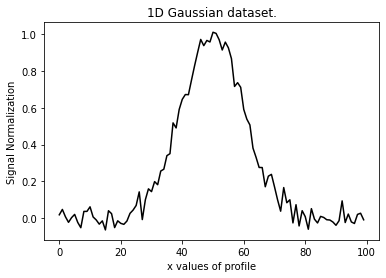

In [3]:
xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Signal Normalization")
plt.show()

We can also plot its `noise_map` (which in this example are all constant values) as a standalone 1D plot or
as error bars on the `data`.

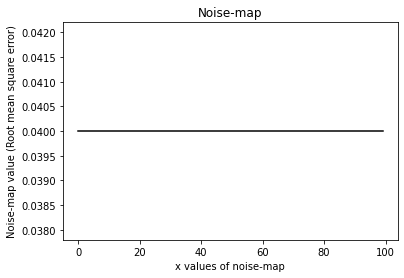

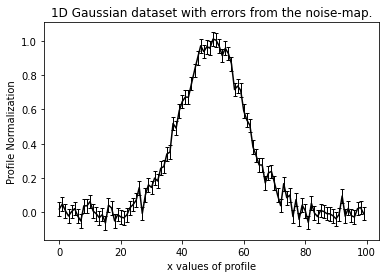

In [4]:
plt.plot(xvalues, noise_map, color="k")
plt.title("Noise-map")
plt.xlabel("x values of noise-map")
plt.ylabel("Noise-map value (Root mean square error)")
plt.show()

plt.errorbar(
    xvalues, data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.title("1D Gaussian dataset with errors from the noise-map.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()

__Model Parameterization__

We now wish to define a model that can fit the signal in this data.

What model could fit this data? The obvious choice is a one-dimensional `Gaussian` defined as:

\begin{equation*}
g(x, I, \sigma) = \frac{N}{\sigma\sqrt{2\pi}} \exp{(-0.5 (x / \sigma)^2)}
\end{equation*}

Where:

x - Is an x-axis coordinate where the `Gaussian` is evaluated.
N - Describes the overall normalization of the Gaussian.
$\sigma$ - Describes the size of the Gaussian.

This simple equation describes our model, a 1D `Gaussian`, and it has 3 parameters, $(x, N, \sigma)$. Using different
values of these 3 parameters we can create a realization of any 1D Gaussian.

__Model Composition__

We now compose the 1D `Gaussian` above as a model in **PyAutoFit**.

First, we write a Python class as follows:

In [5]:
class Gaussian:
    def __init__(
        self,
        centre=30.0,  # <- **PyAutoFit** recognises these constructor arguments
        normalization=1.0,  # <- are the Gaussian`s model parameters.
        sigma=5.0,
    ):
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def profile_from_xvalues(self, xvalues : np.ndarray):
        """
        Calculate the 1D Gaussian profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, using its centre.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


The format of this Python class defines how **PyAutoFit** will compose it as a model, where:

- The name of the class is the name of the model component, in this case, "Gaussian".

- The input arguments of the constructor are the parameters of the model, which we will vary when we fit it to our
 data. In this case, the free parameters are `centre`, `normalization` and `sigma`.

- The default values of the input arguments tell **PyAutoFit** whether a parameter is a single-valued `float` or a
  multi-valued `tuple`. For the `Gaussian` class, no input parameters are a tuple and we will show an example of a
  tuple input in a later tutorial).

- It includes functions associated with that model component, for example the `profile_from_xvalues` function, which
  allows an instance of a `Gaussian` to create its 1D representation as a NumPy array.

To compose the model using the `Gaussian` class above we use the **PyAutoFit** `Model` object.

In [6]:
model = af.Model(Gaussian)
print("Model `Gaussian` object: \n")
print(model)

Model `Gaussian` object: 

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (normalization, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 25.0)


We can inspect the model to note that it indeed has a total of 3 parameters (why this is called `prior_count` will be
explained in section 3):

In [ ]:
print(model.prior_count)

__Model Mapping__

At the core of **PyAutoFit** is how it map Python classes that are set up via the `Model` object to instances of
that Python classes, where the values of its parameters are set during this mapping.

For example, we below create an `instance` of the model, by mapping a list of physical values of each parameter as
follows.

In [ ]:
instance = model.instance_from_vector(vector=[30.0, 2.0, 3.0])

This is an instance of the `Gaussian` class.

In [ ]:
print("Model Instance: \n")
print(instance)

It has the parameters of the `Gaussian` with the values input above.

In [ ]:
print("Instance Parameters \n")
print("x = ", instance.centre)
print("normalization = ", instance.normalization)
print("sigma = ", instance.sigma)

We can use the functions associated with this class, specifically the `profile_from_xvalues` function, to create a
realization of the Gaussian and plot it.

In [ ]:
realization = instance.profile_from_xvalues(xvalues=xvalues)

plt.plot(xvalues, realization, color="r")
plt.title("1D Gaussian Realization.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()
plt.clf()

__Discussion__

Whilst the simple example above is informative, it may be somewhat underwhelming. Afterall, how difficult would it
have been to write Python code that defines this `Gaussian` with those values yourself? Why bother setting up the
`Gaussian` as a `Model` and using the `model.instance_from_vector` command when you could of just set up an instance
of the Gaussian by passing it the parameters manually yourself, e.g.:

`instance = Gaussian(centre=30.0, normalization=2.0, sigma=3.0)`

The reason, is because model composition and mapping get very complicated very quickly. In section 3, we'll introduce
priors, which also need to be fully for when performing model mapping. Later tutorials will compose models with 10+
parameters, which require high levels of customization in their parameterization. At the end of chapter 1 we'll use
**PyAutoFit** to build multi-level models from hierarchies of Python classes that potentially comprise hundreds of
parameters!

Therefore, things might seem somewhat and unnecessary right now, but the tools we're covering now will enable very
complex models to be composed, mapped and fitted by the end of this chapter!

__Wrap Up__

In this section, we introduced how to parameterize and compose a model and define priors for each of its parameters.
This used Python classes and allowed us to map input values to instances of this Python class. Nothing we've introduced
so far was particularly remarkable, but it has presented us with the core interface we'll use to do advanced model
fitting in later tutorials.

Finally, quickly think about a model you might want to fit. How would you write it as a Python class using the format
above? What are the free parameters of you model? Are there multiple model components you are going to want to fit to
your data data?

If you decide to add a new model-component to the `autofit_workspace` specific to your model-fitting task, first
checkout the following script, which explains how to set up the **PyAutoFit** configuration files associated with
your model.

`autofit_workspace/notebooks/overview/new_model_component/new_model_component.ipynb`

Section 2: Model Fitting
========================

In this section, we'll fit the 1D `Gaussian` from the previous tutorial to the data containing that Gaussian, and
learn how to quantify the goodness-of-fit.

The shape of the data gives us its xvalues, the x coordinates we evaluate our model 1D `Gaussian` on.

In [ ]:
xvalues = np.arange(data.shape[0])
print(xvalues)

Lets plot the data and noise-map we're going to fit again, just as a reminder of what it looks like.

In [ ]:
plt.errorbar(
    xvalues, data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()
plt.clf()

__Model Data__

So, how do we actually go about fitting our `Gaussian` model to this data? First, we need to be able to generate
an image of our 1D `Gaussian` model. For this, we can use the `Gaussian` we defined in section 1.

In [ ]:
gaussian = model.instance_from_vector(vector=[60.0, 20.0, 15.0])

model_data = gaussian.profile_from_xvalues(xvalues=xvalues)

plt.plot(xvalues, model_data, color="r")
plt.title("1D Gaussian model.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()
plt.clf()

It is often more informative to plot the `data` and `model_data` on the same plot for comparison.

In [ ]:
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.show()
plt.close()

__Residuals__

Different values of `centre`, `normalization` and `sigma` change the `Gaussian`'s appearance, have a go at editing some
of the values input into `instance_from_vector()` above to see this behaviour.

Lets recap. We've defined a model which is a 1D `Gaussian` and given a set of parameters for that model $(x, N, \sigma)$
we can create `model_data` of the `Gaussian`. We have some data of a 1D `Gaussian` we want to fit this model with,
so as to determine the values of $(x, N, \sigma)$ from which it was created. So how do we do that?

Simple, we take the our `data` and `model_data` and subtract the two to get a residual-map.

In [ ]:
residual_map = data - model_data
plt.plot(xvalues, residual_map, color="r")
plt.title("Residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Residuals")
plt.show()
plt.clf()

__Normalized Residuals__

Clearly, this model is not a good fit to the data -- which was to be expected as they looked nothing alike!

Next, we want to quantify how good (or bad) the fit actually was, via some goodness-of-fit measure. This measure
needs to account for noise in the data, after all if we fit a pixel badly simply because it was very noisy we want
our goodness-of-fit to account for that.

To account for noise, we take our `residual_map` and divide it by the `noise_map`, to get the normalized residual-map.

In [ ]:
normalized_residual_map = residual_map / noise_map
plt.plot(xvalues, normalized_residual_map, color="r")
plt.title("Normalized residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Normalized Residuals")
plt.show()
plt.clf()

__Chi Squared__

We're getting close to a goodness-of-fit measure, but there is still a problem, we have negative and positive values
in the normalized residual-map. A value of -0.2 represents just as good of a fit as a value of 0.2, therefore we want
them to both be the same value.

Thus, we next define a chi-squared-map, which is the `normalized_residual_map` squared. This makes negative and
positive values both positive and thus defines them on a common overall scale.

In [ ]:
chi_squared_map = (normalized_residual_map) ** 2
plt.plot(xvalues, chi_squared_map, color="r")
plt.title("Chi-Squareds of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Chi-Squareds")
plt.show()
plt.clf()

Great, even when looking at a chi-squared-map its clear that our model gives a rubbish fit to the data!

Finally, we want to reduce all the information in our `chi_squared_map` into a single goodness-of-fit measure. To do
this we define the `chi_squared`, which is the sum of all values on the chi-squared-map.

In [ ]:
chi_squared = np.sum(chi_squared_map)
print("Chi-squared = ", chi_squared)

The lower our chi-squared, the fewer residuals in the fit between our model and the data and therefore the better our
fit!

__Likelihood__

From the chi-squared we can then define our final goodness-of-fit measure, the `log_likelihood`, which is the
chi-squared value multiplied by -0.5.

In [ ]:
log_likelihood = -0.5 * chi_squared
print("Log Likelihood = ", log_likelihood)

Why is the log likelihood the chi-squared multiplid by -0.5? Lets not worry about. This is simply the standard
definition of a log_likelihood in statistics (it relates to the specific case of the noise properties in our dataset
being Gaussian). For now, just accept that this is  what a log likelihood is and if we want to fit a model to data our
goal is to thus find the combination of model parameters that maximize the `log_likelihood`.

There is a second quantity that enters the log likelihood, called the `noise_normalization`. This is the log sum of all
noise values squared in our data. Given the noise-map is fixed, the noise_normalization retains the same value for
all models that we fit. Nevertheless, it is good practise to include it in the log likelihood.

In [ ]:
noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))

Again, like the definition of a log likelihood, lets not worry about why a noise normalization is defined in this way
or why its in our goodness-of-fit (it again relates to the noise properties of our dataset being Gaussian). Lets just
accept for now that this is how it is in statistics.

Thus, we now have the definition of a log likelihood that we'll use hereafter in all **PyAutoFit** tutorials.

In [ ]:
log_likelihood = -0.5 * (chi_squared + noise_normalization)
print("Log Likelihood = ", log_likelihood)

__Fitting Functions__

If you are familiar with model-fitting, you will have probably heard of terms like 'residuals', 'chi-squared' and
'log_likelihood' before. These are the standard metrics by which a model-fit`s quality is quantified. They are used for
model fitting in general, so not just when your data is 1D but when its a 2D image, 3D datacube or something else
entirely!

If you have not performed model fitting before and these terms are new to you, make sure you are clear on exactly what
they all mean as they are at the core of all model fitting performed in **PyAutoFit** (and statistical inference in
general)!

So to recap:

 - We can define a model components in **PyAutoFit**, like our `Gaussian`, using Python classes that follow a certain
 format.

 - The model component can be set up as a `Model` and have its parameters mapped to an instance of the
 `Gaussian` class via `instance_from_vector` function.

 - We can use this model instance to create model-data of our `Gaussian` and compare it to data and quantify the
 goodness-of-fit via a log likelihood.

Thus we have everything we need to fit our model to our data! So, how do we go about finding the best-fit model?
That is, the model which maximizes the log likelihood.

The most simple thing we can do is guess parameters, and when we guess parameters that give a good fit, guess another
set of parameters near those values. We can then repeat this process, over and over, until we find a really good model!

For our `Gaussian` this works pretty well, below I've fitted 3 different `Gaussian` models and ended up landing on
the best-fit model (the model I used to create the dataset in the first place!).

For convenience, I've create functions which compute the chi-squared-map and log likelihood of a model-fit, alongside a
method to plot a profile, residual-map or chi-squared-map.

In [ ]:


def chi_squared_map_from_data_and_model_data(data, noise_map, model_data):

    residual_map = data - model_data
    normalized_residual_map = residual_map / noise_map

    return (normalized_residual_map) ** 2


def log_likelihood_from_data_and_model_data(data, noise_map, model_data):

    chi_squared_map = chi_squared_map_from_data_and_model_data(
        data=data, noise_map=noise_map, model_data=model_data
    )
    chi_squared = sum(chi_squared_map)
    noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))
    log_likelihood = -0.5 * (chi_squared + noise_normalization)

    return log_likelihood


def plot_line(xvalues, line, color="k", errors=None, ylabel=None):

    plt.errorbar(
        x=xvalues, y=line, yerr=errors, color=color, ecolor="k", elinewidth=1, capsize=2
    )
    plt.title("Chi-Squared of model-data fit to 1D Gaussian data.")
    plt.xlabel("x values of profile")
    plt.ylabel(ylabel)
    plt.show()
    plt.clf()

__Guess 1__

In [ ]:

gaussian = model.instance_from_vector(vector=[50.0, 10.0, 5.0])
model_data = gaussian.profile_from_xvalues(xvalues=xvalues)
chi_squared_map = chi_squared_map_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
plot_line(xvalues=xvalues, line=chi_squared_map, color="r", ylabel="Chi-Squareds")

log_likelihood = log_likelihood_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
print("Log Likelihood:")
print(log_likelihood)

__Guess 2__

In [ ]:

gaussian = model.instance_from_vector(vector=[50.0, 25.0, 5.0])
model_data = gaussian.profile_from_xvalues(xvalues=xvalues)
chi_squared_map = chi_squared_map_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
plot_line(xvalues=xvalues, line=chi_squared_map, color="r", ylabel="Chi-Squareds")

log_likelihood = log_likelihood_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
print("Log Likelihood:")
print(log_likelihood)

__Guess 3__

In [ ]:

gaussian = model.instance_from_vector(vector=[50.0, 25.0, 10.0])
model_data = gaussian.profile_from_xvalues(xvalues=xvalues)
chi_squared_map = chi_squared_map_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
plot_line(xvalues=xvalues, line=chi_squared_map, color="r", ylabel="Chi-Squareds")

log_likelihood = log_likelihood_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
print("Log Likelihood:")
print(log_likelihood)

__Wrap Up__

You can now perform model-fitting with **PyAutoFit**! All we have to do is guess lots of parameters, over and over and
over again, until we hit a model with a high log_likelihood. Yay!

Of course, you're probably thinking, is that really it? Should we really be guessing models to find the best-fit?

Obviously, the answer is no. Imagine our model was more complex, that it had many more parameters than just 3.
Our approach of guessing parameters won't work -- it could take days, maybe years, to find models with a high
log likelihood, and how could you even be sure they ware the best-fit models? Maybe a set of parameters you never tried
provide an even better fit?

Of course, there is a much better way to perform model-fitting, and in the next sections we'll take you through how
to do such fitting in **PyAutoFit**, by setting up our model with priors and performing a non-linear search.

__Your Model__

To end, its worth quickly again thinking about the model you ultimately want to fit to do your science. In this example,
we extended the `Gaussian` class to contain the function we needed to generate an image of the `Gaussian` and thus
generate the model-image we need to fit our data. For your model fitting problem can you do something similar?
Or is your model-fitting task a bit more complicated than this? Maybe there are more model component you want to
combine or there is an inter-dependency between models?

Probabilistic programming languages provides a lot of flexibility in how you use your model instances, so whatever
your problem you should find that it is straight forward to find a solution. But, whatever you need to do at its
core your modeling problem will break down into the tasks we did in this tutorial:

- Use your model to create some model data.
- Subtract it from the data to create residuals.
- Use these residuals in conjunction with your noise-map to define a log likelihood.
- Find the highest log likelihood models.

So, get thinking about how these steps would be performed for your model!

Section 3: Parameter Space And Priors
=====================================

In the previous section, we defined fitting functions that allowed us to create model-data using realizations of a
1D `Gaussian` model and fit it to the data. We achieved a good fit, but only by guessing values of parameters. In the
next two sections we are going to learn how to fit a model to data properly, which means we first need to define
concepts of a parameter space and priors.

__Parameter Space__

If mathematics, you will have learnt that we can write a simple function as follows:

$f(x) = x^2$

In this function, when we input the parameter $x`$ in to the function $f$, it returns a value $f(x)$. The mappings
between values of $x$ and $f(x)$ define what we can call the parameter space of this function (and if you remember
your math classes, the parameter space of the function $f(x) = x^2$ is a parabola).

A function can of course have multiple parameters:

$f(x, y, z) = x + y^2 - z^3$

This function has 3 parameters, $x$, $y$ and $z$. The mappings between $x$, $y$ and $z$ and $f(x, y, z)$ define another
parameter space, albeit this parameter space now has 3 dimensions. Nevertheless, just like we could plot a parabola to
visualize the parameter space $f(x) = x^2$, we could visualize this parameter space as 3 dimensional surface.

In the previous tutorial, we used realizations of the `Gaussian` class to fit data with a model so as to return a log
likelihood.

This process can be thought of as us computing a likelihood from a function, just like our functions $f(x)$ above.
However, the log likelihood function is not something that we can write down analytically as an equation and its
behaviour is inherently non-linear. Nevertheless, it is a function, and if we put the same values of model
parameters into this function the same value of log likelihood will be returned.

Therefore, we can write this log likelihood function as follows, where the parameters $(x, N, \sigma)$ are again
the parameters of our `Gaussian`:

$f(x, N, \sigma) = log_likelihood$

By expressing the likelihood in this way we have defined a parameter space! The solutions to this function cannot be
written analytically and it is highly complex and non-linear. However, we have already learnt how we can use this
function to determine a log likelihood, by creating realizations of the Gaussian and comparing them to the data.

__Priors__

We are now thinking about our model and log likelihood function as a parameter space, which is crucial for
understanding how we will fit the model to data in the next tutorial. Before we do that, we need to consider one more
concept, how do we define where in parameter space we search for solutions? What values of model parameters do we
consider viable solutions?

A parameter, say, the `centre` of the `Gaussian`, could in principle take any value between negative and positive
infinity. However, when we inspect the data it is clearly confined to values between 0.0 and 100.0, therefore we should
define a parameter space that only contains these solutions as these are the only physically plausible values
of `centre` (e.g. between 0.0 --> 100.0).

These are called the 'priors'. Our priors define where parameter space has valid solutions, and throughout these
tutorials we will use three types of prior:

- UniformPrior: The permitted values of a parameter are between a `lower_limit` and `upper_limit` and we assign equal
probability to all solutions between these limits. For example, the `centre` of the `Gaussian` will typically assume
a uniform prior between 0.0 and 100.0.

- GaussianPrior: The permitted values of a parameter whose probability is tied to a Gaussian distribution with
a `mean` and width `sigma`. For example, the `sigma` of the `Gaussian` will typically assume Gaussian prior with mean
10.0 and sigma 5.0.

__Model Mapping via Priors__

We can again use **PyAutoFit** to set the `Gaussian` as a model and map it to instances of the `Gaussian`, however
we can now do this via priors.

In [ ]:
model = af.Model(Gaussian)
print("Model `Gaussian` object: \n")
print(model)

We now set the prior for each parameter.

In [ ]:
model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.normalization = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.sigma = af.GaussianPrior(mean=10.0, sigma=5.0)

As a quick reminder, we have seen that using this `Model` we can create an `instance` of the model, by mapping a
list of physical values of each parameter as follows.

In [ ]:
instance = model.instance_from_vector(vector=[1.0, 2.0, 3.0])
print("Instance Parameters \n")
print("x = ", instance.centre)
print("normalization = ", instance.normalization)
print("sigma = ", instance.sigma)

Priors are used to create model instances via a mapping analogous to the one above, but from a unit-vector of values.

This vector is defined in the same way as the vector above but with values spanning from 0 -> 1, where the unit values
are mapped to physical values via the prior, for example:

For the UniformPrior defined between 0.0 and 100.0:

- An input unit value of 0.5 will give the physical value 5.0.
- An input unit value of 0.8 will give te physical value 80.0.

For a GaussianPrior defined with mean 10.0 and sigma 5.0:

- An input unit value of 0.5 (e.g. the centre of the Gaussian) will give the physical value 10.0.
- An input unit value of 0.8173 (e.g. 1 sigma confidence) will give te physical value 1.9051.

Lets take a look:

In [ ]:
instance = model.instance_from_unit_vector(unit_vector=[0.5, 0.3, 0.8173])

print("Model Instance: \n")
print(instance)

print("Instance Parameters \n")
print("x = ", instance.centre)
print("normalization = ", instance.normalization)
print("sigma = ", instance.sigma)

__How Are Priors Actually Used?__

Priors allow us to map unit vectors to physical parameters and therefore define a parameter space. However, the actual
process of mapping unit-values to physical values in this way is pretty much all handled by **PyAutoFit** 
"behind ths scenes" and is not something you'll explicitly do yourself. Nevertheless, this is core concept of any
model-fitting exercise and is why we have covered it in this tutorial. 

In the next section, we'll see how this mapping between unit and physical values is built-in to the algorithms we 
use to perform model-fitting!

__Limits__

We can also set physical limits on parameters, such that a model instance cannot generate parameters outside of a
specified range.

For example, a `Gaussian` cannot have a negative normalization, so we can set its lower limit to a value of 0.0.

In [ ]:
model.normalization = af.GaussianPrior(
    mean=0.0, sigma=1.0, lower_limit=0.0, upper_limit=1000.0
)

The unit vector input below creates a negative normalization value, such that if you uncomment the line
below **PyAutoFit** raises an error.

In [ ]:
# instance = model.instance_from_unit_vector(unit_vector=[0.01, 0.01, 0.01])

__Wrap Up__

In this section, we introduce the notion of a parameter space and priors, which **PyAutoFit**'s model mapping
utilities map between. We are now in a position to perform a model-fit, which will be the subject of the next section.

The description of priors in this tutorial was somewhat of a simplification; we viewed them as a means to map a
unit values of parameters to physical values. In Bayesian inference, priors play a far more important role, as they
define one's previous knowledge of the model before performing the fit. They directly impact the solution that one
infers and ultimately dictate how the model-fitting is performed.

The aim of these lectures is not to teach the reader the details of Bayesian inference but instead set you up with the
tools necessary to perform a model-fit. Nevertheless, it is worth reading up on Bayesian inference and priors at any of
the following links:

https://seeing-theory.brown.edu/bayesian-inference/index.html

https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348

Section 4: Non-linear Search
============================

Its finally time to take our model and fit it to data.

So, how do we infer the parameters for the 1D `Gaussian` that give a good fit to our data?  Previously, we tried a very
basic approach, randomly guessing models until we found one that gave a good fit and high log_likelihood. We discussed
that this was not a viable strategy for more complex models. Surprisingly, this is the basis of how model fitting
actually works!

Basically, our model-fitting algorithm guesses lots of models, tracking the log likelihood of these models. As the
algorithm progresses, it begins to guess more models using parameter combinations that gave higher log_likelihood
solutions previously. If a set of parameters provided a good fit to the data previously, a model with similar values
probably will too.

This is called a non-linear search, and is where the notion of a "parameter space" comes in. We are essentially
searching the parameter space defined by the log likelihood function we introduced in the previous tutorial. Why is it
called non-linear? Because this function is non-linear.

Non linear searches are a common tool used by scientists in a wide range of fields. We will use a non-linear search
algorithm called `Emcee`, which for those familiar with statistic inference is a Markov Chain Monte Carlo (MCMC)
method. For now, lets not worry about the details of how Emcee actually works. Instead, just picture that a non-linear
search in **PyAutoFit** operates as follows:

 1) Randomly guess a model and map the parameters via the priors to an instance of the model, in this case
 our `Gaussian`.

 2) Use this model instance to generate model data and compare this model data to the data to compute a log likelihood.

 3) Repeat this many times, choosing models whose parameter values are near those of models which have higher log
 likelihood values. If a new model's log likelihood is higher than previous models, new models will be chosen with
 parameters nearer this model.

The idea is that if we keep guessing models with higher log-likelihood values, we will inevitably `climb` up the
gradient of the log likelihood in parameter space until we eventually hit the highest log likelihood models.

To be clear, this overly simplified description of an MCMC algorithm is not how `Emcee` actually works in detail. We
are omitting crucial details on how our priors impact our inference as well as how the MCMC algorithm provides us with
reliable errors on our parameter estimates. The goal of this chapter to teach you how to use **PyAutoFit**, not the
actual details of Bayesian inference. If you are interested in the details of how MCMC works, I recommend you checkout
the following web links:

https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50


Lets remind ourselves what the data looks like, using defining a `plot_line` method for convenience.

Note that this function has tools for outputting the images to hard-disk as `.png` files, which we'll use later
in this section.

In [ ]:


def plot_line(
    xvalues,
    line,
    title=None,
    ylabel=None,
    errors=None,
    color="k",
    output_path=None,
    output_filename=None,
):
    """
    Plot a 1D line of data on a plot of x versus y, where the x-axis is the x coordinate of the line and the y-axis
    is the normalization of the line at that coordinate.

    The function include options to output the image to the hard-disk as a .png.

    Parameters
    ----------
    xvalues : np.ndarray
        The x-coordinates the profile is defined on.
    line : np.ndarray
        The normalization values of the profile which are plotted.
    ylabel : str
        The y-label of the plot.
    output_path : str
        The path the image is to be output to hard-disk as a .png.
    output_filename : str
        The filename of the file if it is output as a .png.
    output_format : str
        Determines where the plot is displayed on your screen ("show") or output to the hard-disk as a png ("png").
    """
    plt.errorbar(
        x=xvalues, y=line, yerr=errors, color=color, ecolor="k", elinewidth=1, capsize=2
    )
    plt.title(title)
    plt.xlabel("x value of profile")
    plt.ylabel(ylabel)
    if output_filename is None:
        plt.show()
    else:
        if not path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(path.join(output_path, f"{output_filename}.png"))
    plt.clf()


xvalues = np.arange(data.shape[0])

plot_line(xvalues=xvalues, line=data, errors=noise_map, title="Data", ylabel="Data")

__Analysis__

The non-linear search requires an `Analysis` class, which:

 - Receives the data to be fitted and prepares it so the model can fit it.

 - Defines the `log_likelihood_function` used to compute the `log_likelihood` from a model instance.

 - Passes this `log_likelihood` to the non-linear search so that it can determine parameter values for the the next
 model that it samples.

For our 1D `Gaussian` model-fitting example, here is our `Analysis` class (read the comment in 
the `log_likelihood_function` for a description of how model mapping is used to set up the model that each iteration
of the non-linear search fits):

In [ ]:


class Analysis(af.Analysis):
    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):

        """
        The `instance` that comes into this method is an instance of the `Gaussian` class above, with the parameters
        set to values chosen by the non-linear search (These are commented out to prevent excessive print statements
        when we run the non-linear search).

        This instance`s parameter values are chosen by the non-linear search based on the priors of each parameter and
        the previous models with the highest likelihood result. They are set up as physical values, by mapping unit
        values chosen by the non-linear search.

        print("Gaussian Instance:")
        print("Centre = ", instance.centre)
        print("Normalization = ", instance.normalization)
        print("Sigma = ", instance.sigma)

        Below, we fit the data with the `Gaussian` instance, using its "profile_from_xvalues" function to create the
        model data.
        """
        xvalues = np.arange(self.data.shape[0])

        model_data = instance.profile_from_xvalues(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        chi_squared = sum(chi_squared_map)
        noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))
        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood


__Visualization__

The `Analysis` class above is all we need to fit our model to data with a non-linear search. However, it will provide
us with limited output to inspect whether the fit was a success or not

By extending the `Analysis` class with a `visualize` function, we can perform on-the-fly visualization, which outputs
images of the quantities we described in tutorial 2 to hard-disk as `.png` files using the `plot_line` function above.

Visualization of the results of the search, such as the corner plot of what is caleld the "Probability Density 
Function", are also automatically output during the model-fit on the fly.

In [ ]:

class Analysis(af.Analysis):
    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):

        """
        The `log_likelihood_function` is identical to the previous tutorial.
        """
        xvalues = np.arange(self.data.shape[0])

        model_data = instance.profile_from_xvalues(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        chi_squared = sum(chi_squared_map)
        noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))
        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood

    def visualize(self, paths, instance, during_analysis):

        """
        During a model-fit, the `visualize` method is called throughout the non-linear search. The `instance` passed
        into the visualize method is maximum log likelihood solution obtained by the model-fit so far and it can be
        used to provide on-the-fly images showing how the model-fit is going.
        """
        xvalues = np.arange(self.data.shape[0])

        model_data = instance.profile_from_xvalues(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0

        """
        The visualizer now outputs images of the best-fit results to hard-disk (checkout `visualizer.py`).
        """
        plot_line(
            xvalues=xvalues,
            line=self.data,
            title="Data",
            ylabel="Data Values",
            color="k",
            output_path=paths.image_path,
            output_filename="data",
        )

        plot_line(
            xvalues=xvalues,
            line=model_data,
            title="Model Data",
            ylabel="Model Data Values",
            color="k",
            output_path=paths.image_path,
            output_filename="model_data",
        )

        plot_line(
            xvalues=xvalues,
            line=residual_map,
            title="Residual Map",
            ylabel="Residuals",
            color="k",
            output_path=paths.image_path,
            output_filename="residual_map",
        )

        plot_line(
            xvalues=xvalues,
            line=chi_squared_map,
            title="Chi-Squared Map",
            ylabel="Chi-Squareds",
            color="k",
            output_path=paths.image_path,
            output_filename="chi_squared_map",
        )

__Search__

To perform the non-linear search using `Emcee`, we simply compose our model using a `Model`, instantiate the
`Analysis` class and pass them to an instance of the `Emcee` class.

We also pass a `name` and `path_prefrix`, which specifies that when the results are output to the folder
`autofit_workspace/output` they'll also be written to the folder `howtofit/chapter_1/section_non_linear_search`.

In [ ]:
model = af.Model(Gaussian)

model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.normalization = af.UniformPrior(lower_limit=20.0, upper_limit=40.0)
model.sigma = af.GaussianPrior(mean=10.0, sigma=5.0, lower_limit=0.0, upper_limit=np.inf)

analysis = Analysis(data=data, noise_map=noise_map)

emcee = af.Emcee(
    path_prefix=path.join("howtofit", "chapter_1"), name="section_non_linear_search"
)

__Model Fit__

We begin the non-linear search by calling its `fit` method. This will take a minute or so to run (which is very fast
for a model-fit). Whilst you're waiting, checkout the folder:

`autofit_workspace/output/howtofit`

Here, the results of the model-fit are output to your hard-disk (on-the-fly) and you can inspect them as the non-linear
search runs.

__Unique Identifier__

In the output folder, you will note that results are in a folder which is a collection of random characters. This acts
as a `unique_identifier` of the model-fit, where this identifier is generated based on the model, priors and search that
are used in the fit.

An identical combination of model and search generates the same identifier, meaning that rerunning the
script will use the existing results to resume the model-fit. In contrast, if you change the model, priors or search,
a new unique identifier will be generated, ensuring that the model-fit results are output into a separate folder.

__Contents__

In particular, you'll find (in a folder that is a random string of characters):

 - `model.info`: A file listing every model component, parameter and prior in your model-fit.

 - `model.results`: A file giving the latest best-fit model, parameter estimates and errors of the fit.

 - `output.log`: A file containing the text output of the non-linear search.

 - `samples`: A folder containing the `Emcee` output in hdf5 format.txt (you'll probably never need to look at these,
   but its good to know what they are).

 - `search.summary` A file containing information on the search, including the total number of samples,
 overall run-time and time it takes to evaluate the log likelihood function.

 - `image`: A folder containing `.png` files of the fits defined in the `visualize` method.

 - Other metadata which you can ignore for now (e.g. the pickles folder).

In [ ]:
result = emcee.fit(model=model, analysis=analysis)

print(
    "Emcee has begun running - checkout the autofit_workspace/output/howtofit/section_non_linear_search"
    " folder for live output of the results."
    "This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!"
)

print("Emcee has finished run - you may now continue the notebook.")

__Result__

Once completed, the non-linear search returns a `Result` object, which contains lots of information about the
NonLinearSearch.

A full description of the `Results` object can be found on the **PyAutoFit** readthedocs.

Lets use the `result` it to inspect the maximum likelihood model instance.

In [ ]:
print("Maximum Likelihood Model:\n")
max_log_likelihood_instance = result.samples.max_log_likelihood_instance
print("Centre = ", max_log_likelihood_instance.centre)
print("Normalization = ", max_log_likelihood_instance.normalization)
print("Sigma = ", max_log_likelihood_instance.sigma)

We can use this to plot the maximum log likelihood fit over the data:

In [ ]:
model_data = result.max_log_likelihood_instance.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Emcee model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.show()
plt.close()

__Samples__

Above, we used the `Result`'s `samples` property, which in this case is a `MCMCSamples` object:

In [ ]:
print(result.samples)

This object acts as an interface between the `Emcee` output results on your hard-disk and this Python code. For
example, we can use it to get the parameters and log likelihood of an accepted emcee sample.

In [ ]:
print(result.samples.parameter_lists[10][:])
print(result.samples.log_likelihood_list[10])

We can also use it to get a model instance of the `median_pdf` model, which is the model where each parameter is
the value estimated from the probability distribution of parameter space.

In [ ]:
mp_instance = result.samples.median_pdf_instance
print()
print("Median PDF Model:\n")
print("Centre = ", mp_instance.centre)
print("Normalization = ", mp_instance.normalization)
print("Sigma = ", mp_instance.sigma)

The Probability Density Functions (PDF's) of the results can be plotted using the Emcee's visualization
tool `corner.py`, which is wrapped via the `EmceePlotter` object.

The PDF shows the 1D and 2D probabilities estimated for every parameter after the model-fit. The two dimensional
figures can show the degeneracies between different parameters, for example how increasing $\sigma$ and decreasing
the normalization $N$ can lead to similar likelihoods and probabilities.

In [ ]:
import autofit.plot as aplt

emcee_plotter = aplt.EmceePlotter(samples=result.samples)
emcee_plotter.corner()

The PDF figure above can be seen to have labels for all parameters, whereby sigma appears as a sigma symbol, the
normalization is `N`, and centre is `x`. This is set via the config file `config/notation/label.ini`. When you write
your own model-fitting code with **PyAutoFit**, you can update this config file so your PDF's automatically have the
correct labels.

Section 5: Complex Models
=========================

Up to now, we've fitted a very simple model, a 1D `Gaussian` with 3 free parameters. In this tutorial, we'll look at
how **PyAutoFit** allows us to compose and fit models of arbitrary complexity.

To begin, you should check out the module `autofit_workspace/howtofit/chapter_1_introduction/profiles.py`.

In previous tutorials we used the module `gaussian.py` which contained only the `Gaussian` class. The `profiles.py`
includes a second profile, `Exponential`, which like the `Gaussian` class is a model-component that can be fitted to
data.

Up to now, our data has always been generated using a single `Gaussian` profile. Thus, we have only needed to fit
it with a single `Gaussian`. In this tutorial, our `dataset` is now a superpositions of multiple profiles. The models
we compose and fit are therefore composed of multiple profiles, such that when we generate the model-data we
generate it as the sum of all individual profiles in our model.

Defining a model using multiple model components is straight forward in **PyAutoFit**, using a `Collection`
object.

In [ ]:
model = af.Collection(
    gaussian_0=af.Model(Gaussian), gaussian_1=af.Model(Gaussian)
)

We can manually set the prior on every parameter as follows, and confirm the overall model has 6 free parameters:

In [ ]:
model.gaussian_0.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.gaussian_0.normalization = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.gaussian_0.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.gaussian_1.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.gaussian_1.normalization = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.gaussian_1.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)

print(model.prior_count)

A `Collection` behaves like a `Model` but contains a collection of model components. For example, it
creates a model instance by mapping a list of parameters, which in this case is 6 (3 for the `Gaussian` (centre,
normalization, sigma) and 3 for the `Exponential` (centre, normalization, rate)).

In [ ]:
instance = model.instance_from_vector(vector=[0.1, 0.2, 0.3, 0.4, 0.5, 0.01])

This `instance` contains each of the model components we defined above, using the input argument name of the
`Collection` to define the attributes in the `instance`:

In [ ]:
print("Instance Parameters \n")
print("x (Gaussian 0) = ", instance.gaussian_0.centre)
print("normalization (Gaussian 0) = ", instance.gaussian_0.normalization)
print("sigma (Gaussian 0) = ", instance.gaussian_0.sigma)
print("x (Gaussian 1) = ", instance.gaussian_1.centre)
print("normalization (Gaussian 1) = ", instance.gaussian_1.normalization)
print("sigma (Gaussian 1) = ", instance.gaussian_1.sigma)

Using `Collections`'s we could now define an `Analysis` class that allows us to fit models with as many `Gaussians`
in the model as we like, alongside other 1D profiles like a symmetric `Exponential`. The **PyAutoFit** docs have
example scripts and tutorials showing how to do this; but for this workshop we'll instead jump to the Astronomy
use case in lecture 2.